In [1]:
import os
import sys
from pathlib import Path
sys.path.insert(1, os.path.realpath(os.path.pardir))

import torch
import torch.nn.functional as F
from torch import nn
import safetensors
import einops

from utils.data_utils import BrainDataset, get_tokenizer
from utils.train_utils import TrainConfig, run_train_model, count_parameters, load_model_weights

from dataclasses import dataclass
from simple_parsing.helpers import Serializable

In [2]:
from peft import LoraConfig
from peft import get_peft_model

from transformers import GPT2Tokenizer
from models.gpt2_model import GPT
import tiktoken
from contextlib import nullcontext
from accelerate import notebook_launcher

import matplotlib.pyplot as plt

In [3]:
from models.bert import BrainBert, BertConfig
from models.vq_brain_per_channel import SoundStream

In [4]:
class Franky(nn.Module): 
    """This is first model which incorporate brain features into LLM"""

    def __init__(self, brain_model, llm_model, tokenizer=None):
        super().__init__()

        self.brain_model = brain_model
        self.projector = nn.Linear(self.brain_model.config.dim, llm_model.config.n_embd)
        self.llm_model= llm_model
        self.tokenizer = tokenizer

        self.date_embeddings = nn.Embedding(num_embeddings=25, embedding_dim=llm_model.config.n_embd)
        
        print("Full Franky: number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self):
        n_params = sum(p.numel() for p in self.parameters())
        return n_params
    
    @property
    def dtype(self) -> torch.dtype:
        return next(self.parameters()).dtype

    @property
    def device(self) -> torch.device:
        return next(self.parameters()).device

    def forward(self, x, targets=None, date_info=None):
        """
        Train model.
        """
        attn_mask = self.brain_model.get_attn_mask_padded(x)
        attn_mask = attn_mask.unsqueeze(1)

        features = self.brain_model(x, attn_mask)
        # features = features[:, :self.brain_model.n_registers]
        
        features = self.projector(features)

        date_emb = self.date_embeddings(date_info)
        date_emb = date_emb.unsqueeze(1)

        features = torch.cat([features, date_emb], axis=1)

        new_idx = targets.clone()
        new_idx[new_idx == -100] = 50256

        loss, logits = self.llm_model.forward(idx=new_idx, prefix=features, targets=targets)

        return loss, logits
    
    def generate(self, x, date_info=None, tokenizer=None):
        device = self.device
        
        x = torch.from_numpy(x[None, ]).to(device).to(self.dtype)

        ### Encoder part
        attn_mask = self.brain_model.get_attn_mask_padded(x)
        attn_mask = attn_mask.unsqueeze(1)

        features = self.brain_model(x, attn_mask)
        # features = features[:, :self.brain_model.n_registers]
        
        features = self.projector(features)

        date_emb = self.date_embeddings(date_info)
        date_emb = date_emb.unsqueeze(1)
        
        features = torch.cat([features, date_emb], axis=1)

        ### Text part
        start = '<|endoftext|>'
        input_ids = tokenizer(start,  return_tensors="pt")['input_ids'].to(self.device)
        
        max_new_tokens = 25
        temperature = 1.0 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
        top_k = 10
        
        with torch.no_grad():
            y = self.llm_model.generate(input_ids, max_new_tokens, prefix=features, temperature=temperature, top_k=top_k)

        stop_tokens_ids = (y == 50256).nonzero()
        end = len(y) if len(stop_tokens_ids)==1 else stop_tokens_ids[1]
        ids_clean = y[1:end]
        
        pred = tokenizer.decode(ids_clean, skip_special_tokens=True)
        return pred

In [5]:
# device='cuda'
vq_config = dict(C=128, n_electrodes=1, levels=[8, 5, 5, 5])
cfg = BertConfig(dim=128, window_size=768//4, n_electrodes=256, mask_ratio=0.75, n_layers=6)

vq_vae = SoundStream(**vq_config)
model = BrainBert(cfg, vq_vae)

self.codebook_size 1000
BertConfig(window_size=192, n_electrodes=256, mask_ratio=0.75, tokenizer_downsample=4, n_layers=6, dim=128, hidden_dim=1024, head_dim=32, n_heads=16, n_kv_heads=16)
Encoder: number of parameters: 13.90M


In [6]:
bert_weights = "/drive/logs/kovalev/bert/real_separable_vq_minmax_spikes/step_95000_loss_1.1254.safetensors"
model = load_model_weights(model, bert_weights)
count_parameters(model)

load compiled weights
Total: 13.90M, Trainable: 13.90M


(13901165, 13901165)

Process ForkProcess-4:
Process ForkProcess-1:
Process ForkProcess-3:
Process ForkProcess-8:
Process ForkProcess-6:
Process ForkProcess-2:
Process ForkProcess-5:
Process ForkProcess-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kovalev/frankenstein/utils/train_utils.py", line 41, in load_model_weights
    safetensors.torch.load_model(model, weights)
  File "/home/kovalev/frankenstein/utils/train_utils.py", line 41, in load_model_weights
    safetensors.torch.load_model(model, weights)
  File "/home/kovalev/frankenstein/utils/train_utils.py", line 41, in load_model_weights
    safetensors.torch.load_model(model, weights)
  File "/home/kovalev/frankenstein/utils/train_utils.py", line 41, in load_model_weights
    safetensors.torch.load_model(

In [7]:
from einops import rearrange

In [8]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

data_path = Path("/drive/data/competitionData")
test_dataset = BrainDataset(data_path / 'test', tokenize_function=get_tokenizer(tokenizer), transform=None)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

x, y, date = next(iter(test_dataloader))
print(x.shape, y.shape, date)

with torch.no_grad():
    loss, pred, masked_ids = model(x, y, date, return_indices=True)

ids = torch.argmax(pred, -1)

indices  = rearrange(ids, 'b t c -> (b c) t') 
quantized = model.tokenizer.quantizer.indices_to_codes(indices)
reconstruct = model.tokenizer.decoder(quantized)
reconstruct = rearrange(reconstruct, '(b c) t e -> b t (c e)', c=256)

Runed processing of the  /drive/data/competitionData/test


/opt/conda/envs/pytorch/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


len: 880
max input len 768
torch.Size([1, 768, 256]) torch.Size([1, 25]) tensor([0])
is_padded.shape torch.Size([1, 192])
time_attn_mask.shape torch.Size([1, 192, 192])
time_attn_mask.shape torch.Size([256, 1, 192, 192])
indices tensor(1000)
indices_out tensor(999)
time_attn_mask torch.Size([256, 1, 192, 192])
self.to_bc_t(tokens_space) torch.Size([256, 192, 128])
time_attn_mask torch.Size([256, 1, 192, 192])
self.to_bc_t(tokens_space) torch.Size([256, 192, 128])
time_attn_mask torch.Size([256, 1, 192, 192])
self.to_bc_t(tokens_space) torch.Size([256, 192, 128])
time_attn_mask torch.Size([256, 1, 192, 192])
self.to_bc_t(tokens_space) torch.Size([256, 192, 128])
time_attn_mask torch.Size([256, 1, 192, 192])
self.to_bc_t(tokens_space) torch.Size([256, 192, 128])
time_attn_mask torch.Size([256, 1, 192, 192])
self.to_bc_t(tokens_space) torch.Size([256, 192, 128])


In [12]:
loss

tensor(3.6870)

In [13]:
recon = reconstruct.detach()
x = x.detach()

binary_mask = (masked_ids==1000)
binary_mask = torch.repeat_interleave(binary_mask, repeats=4, dim=1)
binary_mask = binary_mask.detach()

In [14]:
x_masked_input = binary_mask * x
x_unmasked_input = ~binary_mask * x

recon_masked = binary_mask * recon
recon_unmasked = ~binary_mask * recon

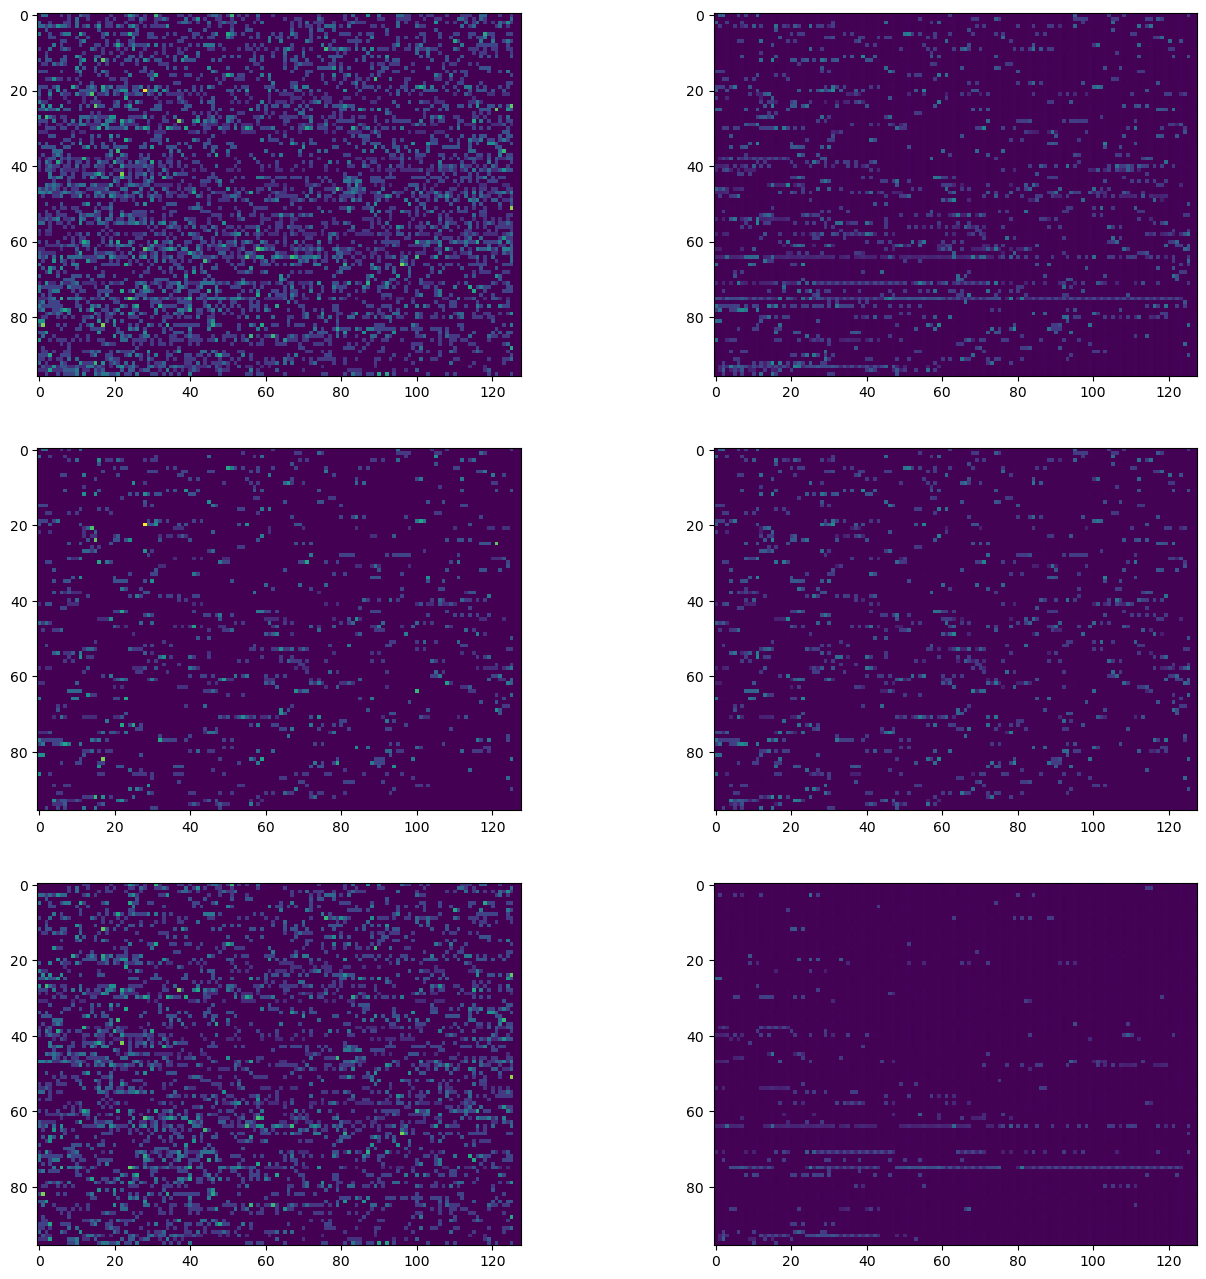

In [17]:
t_st, t_end = 128, 256
c_st, c_end = 32, 128

fig, ax = plt.subplots(3,2, figsize = (16, 16))
ax[0, 0].imshow(x[0, t_st:t_end, c_st:c_end].T, vmax=1)
ax[1, 0].imshow(x_unmasked_input[0, t_st:t_end, c_st:c_end].T, vmax=1)
ax[2, 0].imshow(x_masked_input[0, t_st:t_end, c_st:c_end].T, vmax=1)

ax[0, 1].imshow(recon[0, t_st:t_end, c_st:c_end].T, vmax=1)
ax[1, 1].imshow(recon_unmasked[0, t_st:t_end, c_st:c_end].T, vmax=1)
ax[2, 1].imshow(recon_masked[0, t_st:t_end, c_st:c_end].T, vmax=1)


In [16]:
attn_mask = model.get_attn_mask_padded(x)
attn_mask = attn_mask.expand(4, -1, -1)

AttributeError: 'BrainBert' object has no attribute 'get_attn_mask_padded'

In [ ]:
torch.repeat_interleave(attn_mask, 256, 0).shape

In [ ]:
plt.imshow(attn_mask.detach()[0])

In [9]:
is_padded = (x == 0).all(dim=2, keepdims=True)
is_padded.shape
# is_padded = is_padded[:, ::4].expand(-1, -1, 256)

torch.Size([1, 768, 1])

In [13]:
is_padded[0, :, 0]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

In [14]:
masked_ids[0, :, 0]

tensor([ 791, 1000, 1000,  839, 1000, 1000, 1000, 1000,  879, 1000,  199, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,  999, 1000, 1000, 1000,
          39, 1000, 1000, 1000, 1000, 1000,  961, 1000, 1000, 1000,  999, 1000,
        1000, 1000, 1000,  999, 1000, 1000, 1000, 1000,  999,  994, 1000, 1000,
        1000, 1000, 1000, 1000,   39,  194,  193,  879, 1000, 1000, 1000, 1000,
        1000,  199, 1000, 1000,  999,  999, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,  999, 1000,  999, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,  999, 1000,  999,
         999, 1000, 1000,  999, 1000, 1000, 1000,  999, 1000, 1000, 1000,  999,
        1000,  999, 1000, 1000,  999, 1000, 1000, 1000, 1000,  999, 1000, 1000,
        1000, 1000, 1000, 1000, 1000,  999, 1000, 1000,  999, 1000, 1000, 1000,
        1000, 1000, 1000,  999, 1000, 1000, 1000,  999, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000,  999,  9

In [15]:
masked_ids[is_padded] = -100

In [16]:
masked_ids[0, :, 0]

tensor([ 791, 1000, 1000,  839, 1000, 1000, 1000, 1000,  879, 1000,  199, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,  999, 1000, 1000, 1000,
          39, 1000, 1000, 1000, 1000, 1000,  961, 1000, 1000, 1000,  999, 1000,
        1000, 1000, 1000,  999, 1000, 1000, 1000, 1000,  999,  994, 1000, 1000,
        1000, 1000, 1000, 1000,   39,  194,  193,  879, 1000, 1000, 1000, 1000,
        1000,  199, 1000, 1000, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -1

In [34]:
masked_ids[0, :, 0]

tensor([1000, 1000, 1000, 1000, -100, 1000, 1000, 1000, -100, 1000, 1000, -100,
        1000, 1000, -100, 1000, 1000, 1000, -100, 1000, 1000, -100, -100, 1000,
        1000, 1000, 1000, -100, -100, 1000, 1000, 1000, -100, 1000, 1000, -100,
        -100, -100, 1000, -100, 1000, 1000, 1000, -100, 1000, 1000, 1000, 1000,
        1000, 1000, -100, 1000, 1000, -100, -100, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, -100, 1000, -100, -100, -100, -100, 1000, -100, -100, 1000, 1000,
        1000, 1000, -100, 1000, -100, 1000, 1000, 1000, 1000, 1000, 1000, -100,
        -100, 1000, 1000, 1000, 1000, -100, 1000, 1000, 1000, -100, -100, -100,
        1000, -100, -100, 1000, -100, 1000, -100, -100, 1000, 1000, 1000, 1000,
        -100, 1000, 1000, 1000, 1000, 1000, -100, 1000, 1000, -100, 1000, 1000,
        1000, 1000, -100, 1000, 1000, 1000, 1000, 1000, 1000, -100, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, -1

In [29]:
masked_ids[0][:, 0]

tensor([1000, 1000, 1000, 1000, -100, 1000, 1000, 1000, -100, 1000, 1000, -100,
        1000, 1000, -100, 1000, 1000, 1000, -100, 1000, 1000, -100, -100, 1000,
        1000, 1000, 1000, -100, -100, 1000, 1000, 1000, -100, 1000, 1000, -100,
        -100, -100, 1000, -100, 1000, 1000, 1000, -100, 1000, 1000, 1000, 1000,
        1000, 1000, -100, 1000, 1000, -100, -100, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, -100, 1000, -100, -100, -100, -100, 1000, -100, -100, 1000, 1000,
        1000, 1000, -100, 1000, -100, 1000, 1000, 1000, 1000, 1000, 1000, -100,
        -100, 1000, 1000, 1000, 1000, -100, 1000, 1000, 1000, -100, -100, -100,
        1000, -100, -100, 1000, -100, 1000, -100, -100, 1000, 1000, 1000, 1000,
        -100, 1000, 1000, 1000, 1000, 1000, -100, 1000, 1000, -100, 1000, 1000,
        1000, 1000, -100, 1000, 1000, 1000, 1000, 1000, 1000, -100, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, -1

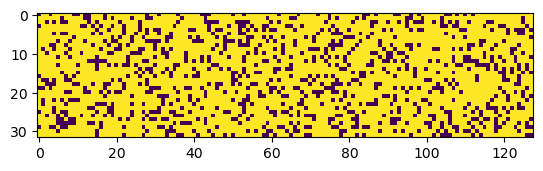

In [18]:
plt.imshow(binary_mask[0, :128, :32].detach().T, vmax=1)

In [12]:
# device = 'cuda'
# dtype = torch.float32

# tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# llm_model = GPT.from_pretrained('gpt2', dict(dropout=0.0)) # 

# ### Create Franky model
# model = Franky(brain_model=brain_model, llm_model=llm_model)

# # weights = '/drive/logs/kovalev/fixed_franky_v2_spikes_only_projector/step_500_loss_3.4384.safetensors'
# # safetensors.torch.load_model(model, weights)

# config = LoraConfig(
#     r=4,
#     lora_alpha=8,
#     lora_dropout=0.1,
#     target_modules=["c_proj", "c_attn", 'c_fc','c_proj'])

# model = get_peft_model(model, config)

# # for param in model.llm_model.parameters():
# #     param.requires_grad = False
    
# for param in model.projector.parameters():
#     param.requires_grad = True

# for param in model.date_embeddings.parameters():
#     param.requires_grad = True

# for param in model.brain_model.parameters():
#     param.requires_grad = True

# # for param in model.llm_model.parameters():
# #     param.requires_grad = False


# # model.print_trainable_parameters()

# print('Initing of the Franky completed')
# count_parameters(model)

In [13]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Clip

train_transform = Compose([
    # AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.15, p=0.1),
    Clip(0, 1, p=1)
])

test_transform = Compose([
    Clip(0, 1, p=1)
])

#### Test forward pass

In [14]:
# data_path = Path("/drive/data/competitionData")
# test_dataset = BrainDataset(data_path / 'test', tokenize_function=get_tokenizer(tokenizer), transform=train_transform)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

# x, y, date = next(iter(test_dataloader))
# print(x.shape, y.shape, date)
# y = model(x, y, date)

### Run training pipeline

In [ ]:
project_name = 'frankenstein'

train_config = TrainConfig(exp_name='all_tokens_train_all',
                           mixed_precision=True, 
                           batch_size=32, 
                           num_workers=3, 
                           pin_memory=True, 
                           warmup_iters=1000,
                           eval_interval=100,
                           grad_accum=1, 
                           weight_decay=1e-5)
# peter path
# data_path = Path(r'C:\Users\peter\alvi\brain2text\competitionData')
data_path = Path("/drive/data/competitionData")
save_folder = Path("/drive/logs/kovalev")

train_dataset = BrainDataset(data_path / 'train', tokenize_function=get_tokenizer(tokenizer), transform=train_transform)
test_dataset = BrainDataset(data_path / 'test', tokenize_function=get_tokenizer(tokenizer), transform=test_transform)

# indices = torch.arange(32).repeat(4)
# train_dataset = torch.utils.data.Subset(train_dataset, indices)
# test_dataset = torch.utils.data.Subset(test_dataset, indices)
args = (model, (train_dataset, test_dataset), train_config, project_name, save_folder)
notebook_launcher(run_train_model, args, num_processes=1)

# simple_train_model(*args)


Runed processing of the  /drive/data/competitionData/train


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
max = 10

for i, sample in enumerate(train_dataset):
    
    x, gt, _ = sample
    
    pred = model.generate(x, tokenizer=tokenizer)
    
    gt[gt==-100]=50256
    gt_txt = tokenizer.decode(gt, skip_special_tokens=True)
    
    print('pred: ', pred)
    print('gt_txt: ', gt_txt)
    print('----')
    if i > max:
        break 

In [ ]:
pred, pred = tokenizer.decode(ids_clean, skip_special_tokens=False)
gt

In [ ]:
model.generate(x, tokenizer=tokenizer)